In [1]:
from PIL import Image, ImageDraw, ImageFilter
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Convolution2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout
from tensorflow.keras import optimizers
from tqdm import tqdm
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (8,6)


### Data augmentation

In [2]:
def flip_image(image,label):
    im= np.fliplr(image)
    l=[300-label[1] ,300-label[0],label[2],label[3]]
    return im,l
def rotate_image(image,label):
    im= np.rot90(image)
    l=[label[2] ,label[3],300-label[1],300-label[0]]
    return im,l

In [3]:
def flip_and_rotate(image,label,flip=False):
    #if flip=False, then only return a list of the 4 rotated images
    #if flip=True, then return 8 images (rotations+flips)
    output_images=[]
    output_labels=[]
    for k in range(4):
        output_images+=[image]
        output_labels+=[label]
        image,label=rotate_image(image,label)
    if flip:
        image,label=flip_image(image,label)
        for k in range(4):
            output_images+=[image]
            output_labels+=[label]
            image,label=rotate_image(image,label)
    return output_images,output_labels

### Generate data

In [2]:
size=300

In [5]:
path = "blue_hand/"
file_list = os.listdir(path)
number_of_images = int(len(file_list) / 2)

image_list = []
value_list = []

np.random.seed(1)                            
                                             
all_image_array = np.arange(number_of_images)
np.random.shuffle(all_image_array)           
                                             

for i in all_image_array:
    image_list += [np.load(path + "image_" + str(i) + ".npy")]
    value_list += [np.load(path + "values_" + str(i) + ".npy")]

# SPLIT THE DATA

split = 900

image_list_training = image_list[:split]
image_list_test = image_list[split:]

value_list_training = value_list[:split]
value_list_test = value_list[split:]

image_training_array = np.asarray(image_list_training)
image_test_array = np.asarray(image_list_test)

value_training_array = np.asarray(value_list_training)
value_test_array = np.asarray(value_list_test)

In [6]:
fliped_and_rotated_images = []
fliped_and_rotated_labels = []

for i in tqdm(range(split)):
    new_im, new_lab = flip_and_rotate(image_training_array[i], value_training_array[i])
    fliped_and_rotated_images += new_im
    fliped_and_rotated_labels += new_lab


all_im = np.asarray(fliped_and_rotated_images)
all_lab = np.asarray(fliped_and_rotated_labels)

100%|██████████| 900/900 [00:00<00:00, 10630.93it/s]


In [31]:
def plot(X,Y):
    plt.imshow(X)
    padding=0
    plt.scatter([Y[0],Y[1],Y[0],Y[1]],\
                [Y[2],Y[3],Y[3],Y[2]],c='red')
    ax = plt.gca()
    ax.add_patch(patches.Rectangle((Y[0],Y[2]),Y[1]-Y[0],Y[3]-Y[2],linewidth=2,edgecolor='r',facecolor='none'))
    return plt

In [8]:
print(np.shape(image_test_array)[0])
samples=np.shape(all_im)[0]+np.shape(image_test_array)[0]
test_samples=np.shape(image_test_array)[0]
print(samples)
print(np.shape(all_im))

155
3755
(3600, 300, 300, 3)


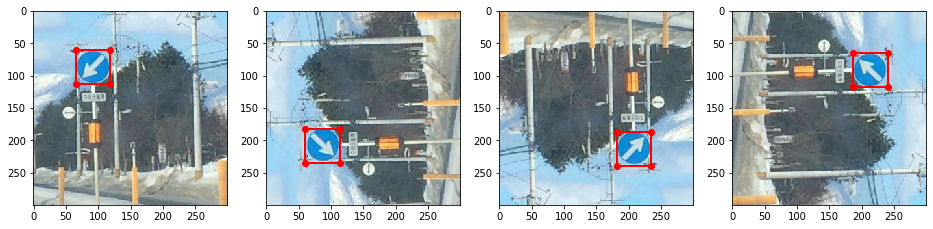

In [9]:
ims,labels=flip_and_rotate(all_im[0],all_lab[0])


plt.figure(figsize=(16,8))
for i in range(4):
    ax= plt.subplot(2,4,i+1)
    im=plot(ims[i],labels[i])

3600
[182.40625    235.         186.80859375 240.        ]


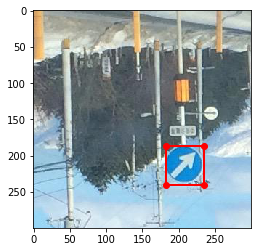

In [10]:
print(np.shape(all_im)[0])
plot(all_im[2],all_lab[2])
print(all_lab[2])

## Preprocessing

#### Histogram stretching

for i in range(samples-test_samples):
    img_yuv = cv2.cvtColor(image_training_array[i], cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    image_training_array[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
for i in range(test_samples):
    img_yuv = cv2.cvtColor(image_test_array[i], cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    image_test_array[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

#### Histograms

In [11]:
row_train=np.zeros((samples-test_samples, size, 3, 1))
for i in tqdm(range(samples-test_samples)):
    for j in range(size):
        for c in range(3):
            row_train[i,j,c]=np.sum(all_im[i,j,:,c])
            
row_test=np.zeros((test_samples, size, 3, 1))
for i in range(test_samples):
    for j in range(size):
        for c in range(3):
            row_train[i,j,c]=np.sum(image_test_array[i,j,:,c])


            
col_train=np.zeros((samples-test_samples, size, 3, 1))
for i in tqdm(range(samples-test_samples)):
    for j in range(size):
        for c in range(3):
            col_train[i,j,c]=np.sum(all_im[i,:,j,c])
            
col_test=np.zeros((test_samples, size, 3, 1))
for i in range(test_samples):
    for j in range(size):
        for c in range(3):
            col_test[i,j,c]=np.sum(image_test_array[i,:,j,c])
            
            
print(row_train.shape)

(3600, 300, 3, 1)


## Normalization

In [12]:
#x_train = x_train.reshape(x_train.shape[0], canvas_size[0], canvas_size[1],3)
#x_test = x_test.reshape(x_test.shape[0],  canvas_size[0], canvas_size[1],3)

#Normalization
all_im = all_im.astype('float32')/255
image_test_array = image_test_array.astype('float32')/255
all_lab = all_lab.astype('float32')/size
value_test_array = value_test_array.astype('float32')/size


#histogram
row_train = row_train.astype('float32')/(size*255)
row_test = row_test.astype('float32')/(size*255)
col_train = col_train.astype('float32')/(size*255)
col_test = col_test.astype('float32')/(size*255)

## Define and train model

In [3]:
img_input = keras.Input(shape=(size, size, 3), name="image")
row_input = keras.Input(shape=(size, 3, 1), name="row")
col_input = keras.Input(shape=(size, 3, 1), name="col")

x = layers.AveragePooling2D(pool_size=(2,2))(img_input)
x = layers.Convolution2D(10, (3,3),activation='relu')(x)
#x = layers.Convolution2D(15, (3,3),activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Convolution2D(10, (3,3),activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Convolution2D(20, (3,3),activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Convolution2D(5, (3,3),activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x_flat = layers.Flatten()(x)
r = layers.Flatten()(row_input)
r = layers.Dense(1000, activation = 'relu')(r)
r = layers.Dense(300, activation = 'relu')(r)
r_flat = layers.Flatten()(r)
c = layers.Flatten()(col_input)
c = layers.Dense(1000, activation = 'relu')(c)
c = layers.Dense(300, activation = 'relu')(c)
c_flat = layers.Flatten()(c)

conc = layers.concatenate([x_flat, r_flat, c_flat])
conc = layers.Dense(200, activation = 'relu')(conc)
pos_pred = layers.Dense(4, name="output")(conc)

model = keras.Model(inputs=[img_input, row_input, col_input], outputs=[pos_pred])

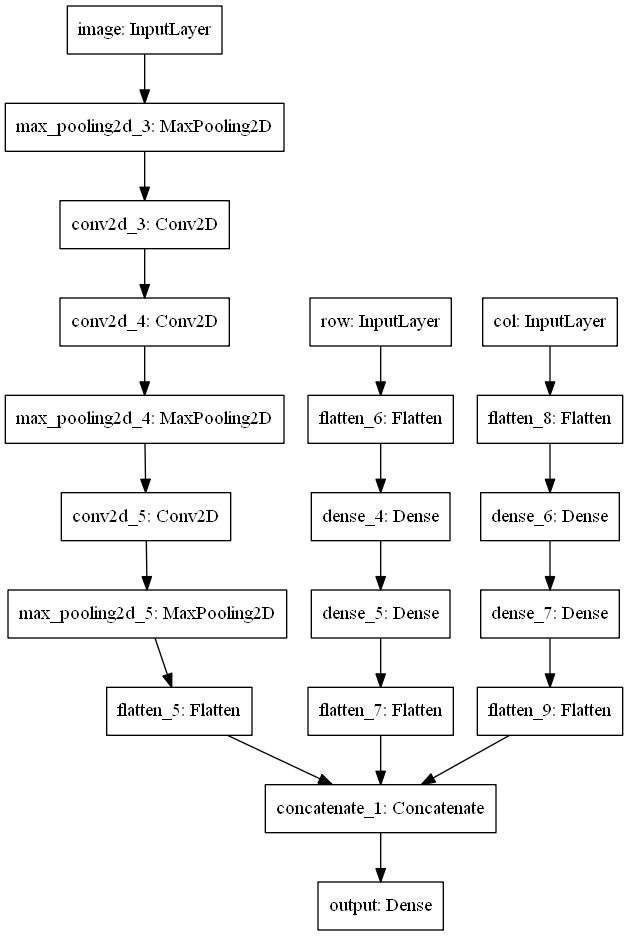

In [4]:
keras.utils.plot_model(model, "second_model.png", show_shapes=False)

In [25]:
model.compile(optimizer='adam',loss='mse')


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 150, 150, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 148, 148, 10) 280         average_pooling2d[0][0]          
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 74, 74, 10)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [27]:
history=model.fit(
    {"image": all_im, "row": row_train, "col": col_train},
    {"output": all_lab},
    epochs=25, 
    batch_size=20, 
    validation_split=0.1, 
    shuffle=True, 
    verbose=2,
)

Epoch 1/25
162/162 - 34s - loss: 0.0387 - val_loss: 0.0102
Epoch 2/25
162/162 - 33s - loss: 0.0085 - val_loss: 0.0081
Epoch 3/25
162/162 - 33s - loss: 0.0058 - val_loss: 0.0042
Epoch 4/25
162/162 - 33s - loss: 0.0040 - val_loss: 0.0030
Epoch 5/25
162/162 - 33s - loss: 0.0030 - val_loss: 0.0025
Epoch 6/25
162/162 - 33s - loss: 0.0025 - val_loss: 0.0026
Epoch 7/25
162/162 - 33s - loss: 0.0021 - val_loss: 0.0019
Epoch 8/25
162/162 - 33s - loss: 0.0019 - val_loss: 0.0019
Epoch 9/25
162/162 - 33s - loss: 0.0016 - val_loss: 0.0017
Epoch 10/25
162/162 - 33s - loss: 0.0015 - val_loss: 0.0017
Epoch 11/25
162/162 - 33s - loss: 0.0013 - val_loss: 0.0015
Epoch 12/25
162/162 - 33s - loss: 0.0012 - val_loss: 0.0015
Epoch 13/25
162/162 - 33s - loss: 0.0011 - val_loss: 0.0015
Epoch 14/25
162/162 - 33s - loss: 0.0010 - val_loss: 0.0014
Epoch 15/25
162/162 - 33s - loss: 9.0015e-04 - val_loss: 0.0012
Epoch 16/25
162/162 - 33s - loss: 8.6729e-04 - val_loss: 0.0014
Epoch 17/25
162/162 - 33s - loss: 8.1340e

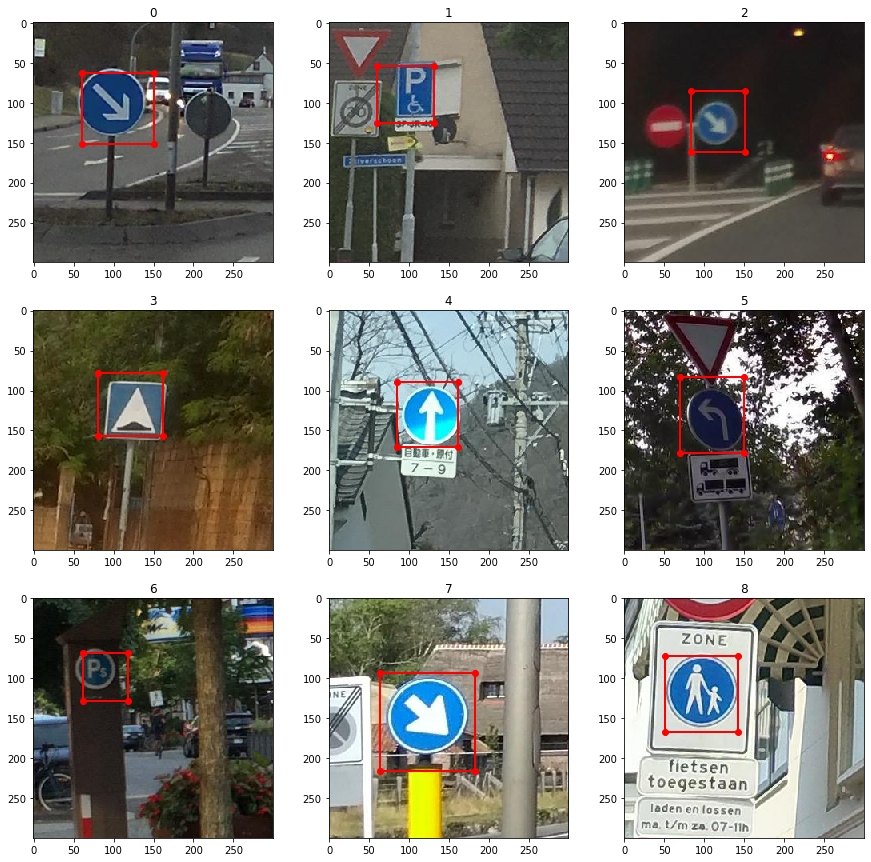

In [33]:
plt.figure(figsize=(15,15))
for i in range(9):
    ax= plt.subplot(3,3,i+1)
    k = random.randint(0,len(image_test_array))-1
    #x=image_test_array[k]
    #r=row_test[k]
    #c=col_test[k]
    x=image_test_array[i]
    #r=row_test[i]
    #c=col_test[i]
    r=np.random.rand(size,3,1)
    c=np.random.rand(size,3,1)
    #r=np.zeros((size,3,1))
    #c=np.zeros((size,3,1))
    y=model.predict({"image": np.array([x]), "row": np.array([r]), "col": np.array([c])})[0]
    im=plot(x,y*size)
    plt.title(i)

In [30]:
model.save('./blue_pre_no_inf.h5')

In [3]:
model = keras.models.load_model('./model_blue_hand_weights.h5')